# Using the coefficients of a logistic regression model as a query vector

Rather than using a logistic regression classifier to score each example in a dataset so that we can find the highest-scoring cases, we show here an approach to use the vector of coefficients from that model as a query in a vector search. Because this approach will be amenable to approximate vector search, it promises to be vastly more scalable than traditional model scoring.

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegressionCV
from sentence_transformers import SentenceTransformer

In [2]:
featurized_parquet_file = 'data/sentence_embeddings.parquet'

text_df = pd.read_parquet(featurized_parquet_file)

# This is the dataset I was using earlier, which was the 'sentiment labelled sentences dataset from the UC Irvine Machine Learning Repository.
# https://archive.ics.uci.edu/dataset/331/sentiment+labelled+sentences)
# text_df = pd.read_csv('data/imdb_labelled.txt', sep='\t', header=None, names=['review', 'sentiment'])
# sentxformer = SentenceTransformer('all-MiniLM-L6-v2')
# text_df['vector'] = sentxformer.encode(text_df['review'].values).tolist()


In [3]:
text_df

review  sentiment  \
0    So there is no way for me to plug it in here i...          0   
1                          Good case, Excellent value.          1   
2                               Great for the jawbone.          1   
3    Tied to charger for conversations lasting more...          0   
4                                    The mic is great.          1   
..                                                 ...        ...   
743  I just got bored watching Jessice Lange take h...          0   
744  Unfortunately, any virtue in this film's produ...          0   
745                   In a word, it is embarrassing.            0   
746                               Exceptionally bad!            0   
747  All in all its an insult to one's intelligence...          0   

                                                vector  
0    [0.08027008920907974, -0.04396028444170952, -0...  
1    [-0.009648566134274006, 0.10622689127922058, 0...  
2    [-0.07081733644008636, 0.07361650466918945, 0....  
3    [-0.0739610344171524, 0.06734045594930649, 0.0...  
4    [-0.09819574654102325, 0.010798277333378792, 0...  
..                                                 ...  
743  [-0.02032049186527729, -0.07333985716104507, 0...  
744  [-0.025788182392716408, 0.007497682701796293, ...  
745  [0.026193976402282715, 0.022175997495651245, 0...  
746  [-0.027648691087961197, -0.004298456944525242,...  
747  [0.00193118117749691, 0.08036555349826813, 0.0...  

[2748 rows x 3 columns]

In [4]:
clf = LogisticRegressionCV(cv=5, scoring='roc_auc', n_jobs=-1, max_iter=10000)
X = [v for v in text_df['vector']]
y = text_df['sentiment']
clf.fit(X, y)

get_mean_xval_score_for_binary_classifier = lambda clf: np.mean([np.max(v) for v in clf.scores_[True]])
get_mean_xval_score_for_binary_classifier(clf)

0.9592656638902367

In [5]:
clf.C_

array([0.35938137])

# Find top-scoring sentences the old-fashioned way

Here we use the classifier object to generate a score for each example.

In [6]:
text_df['score'] = clf.predict_proba(X)[:,1]

text_df.sort_values('score', ascending=False).head(5)[['review', 'score']]

review     score
469                        Looks great and is strong."  0.993846
532        ) some great music, and terrific scenery.    0.993767
725                    Great food and awesome service!  0.992226
332                        The reception is excellent!  0.992001
872  All in all an excellent restaurant highlighted...  0.990908

# Find top-scoring sentences by similarity to coefficient vector

This approach is more scalable because it can be used with approximate vector similarity approaches (Here we compute exact similarity against each example, but we could theoretically use approximate similarity. We'll show that later.)

In [7]:
coef_vector = clf.coef_[0]

text_df['similarity'] = [np.dot(coef_vector, v) for v in text_df['vector']]
text_df.sort_values('similarity', ascending=False).head(5)[['review', 'similarity']]

review  similarity
469                        Looks great and is strong."    5.154482
532        ) some great music, and terrific scenery.      5.141581
725                    Great food and awesome service!    4.919141
332                        The reception is excellent!    4.890396
872  All in all an excellent restaurant highlighted...    4.761271

### About the suspicious similarity between the dot product and the cosine distance

It turns out that the sentence transformer model I'm using here ('all-MiniLM-L6-v2') produces unit vectors, as shown below:

In [8]:
get_vector_length = lambda v: np.sqrt( sum( np.multiply(v, v) ) )

vector_length = [get_vector_length(v) for v in text_df['vector']]
print(f"Vector lengths are all between {np.min(vector_length)} and {np.max(vector_length)}.")

Vector lengths are all between 0.9999998866713405 and 1.0000000984752353.


The vector of model coefficients is not a unit vector, but that only results in the difference between the dot product and the cosine similarity being off by a constant factor (equal to the euclidean length of the coefficient vector).

In [9]:
len(X) # 748
len(X[0]) # 384

384

1.0

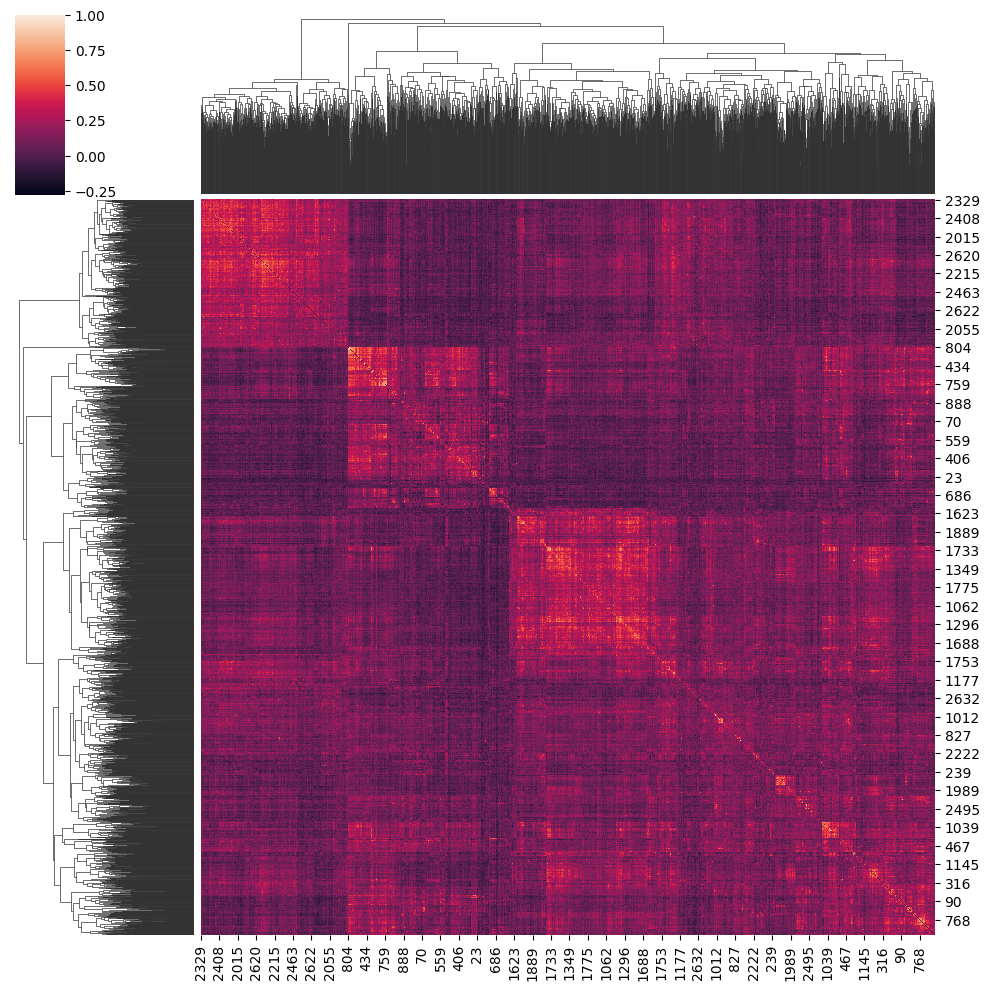

In [10]:
import seaborn as sns

X2d = np.array(X)
X_row_corr = np.corrcoef(X2d)
np.fill_diagonal(X_row_corr, 0.0)
sns.clustermap(X_row_corr)

np.max(X_row_corr)

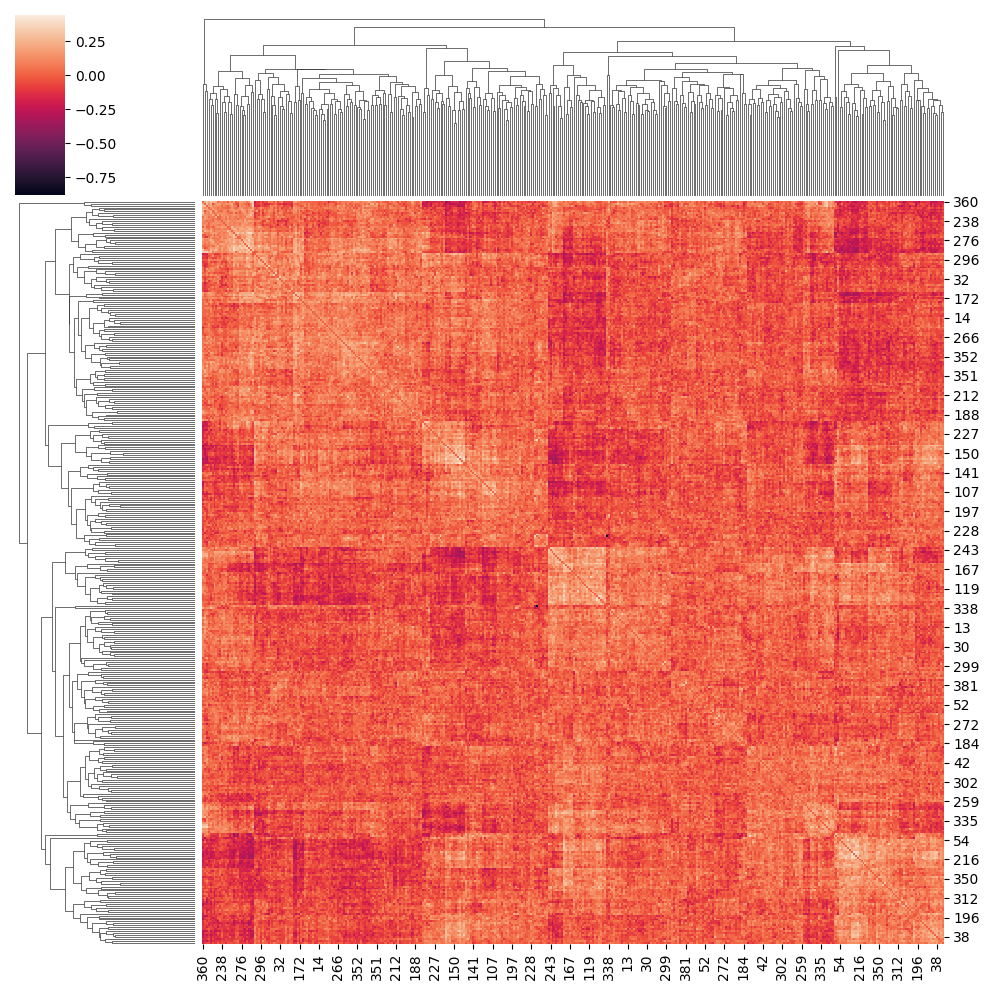

In [11]:
X_column_corr = np.corrcoef(X2d.T)
np.fill_diagonal(X_column_corr, 0)
sns.clustermap(X_column_corr)

# PCA columns are orthogonal

This is what they look like in a clustermap:

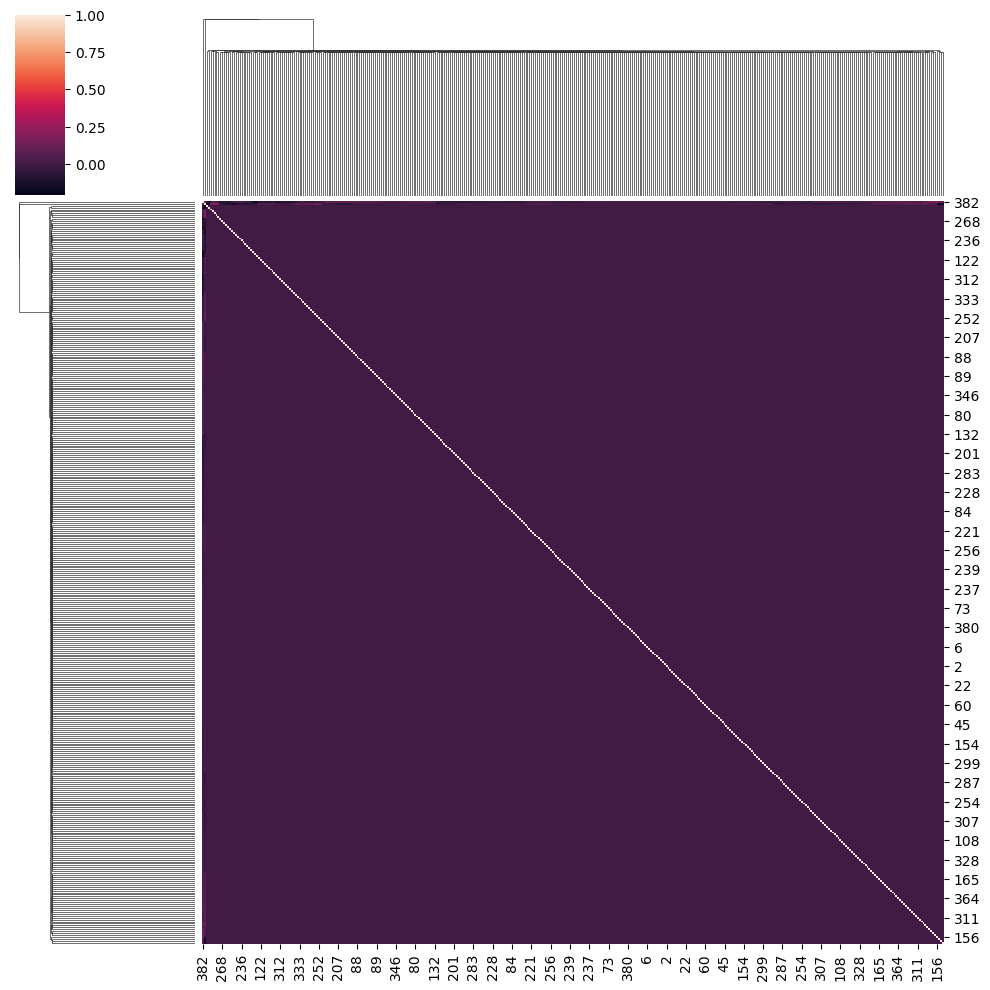

In [12]:
from sklearn.decomposition import PCA
my_pca = PCA(n_components=384).fit(X)
X_pca = my_pca.transform(X)

X_pca_column_corr = np.corrcoef(X_pca.T)
# np.fill_diagonal(X_pca_column_corr, 0)
sns.clustermap(X_pca_column_corr)

## Low-dimensional representation with PCA

In [13]:
len(coef_vector)


384

In [14]:
to_unit_vector = lambda v: v/np.sqrt(np.sum([d**2 for d in v]))

coef_vector_pca = my_pca.transform(np.array(to_unit_vector(coef_vector)).reshape(1, len(coef_vector)))

df_coef_pca = pd.DataFrame({'x': coef_vector_pca[:,0], 'y': coef_vector_pca[:,1], 'z': coef_vector_pca[:,2],
                            'sentiment': None, 'color': '#00FF00'})

df_coef_pca

x         y         z sentiment    color
0 -0.045942  0.104422 -0.777621      None  #00FF00

<Axes: xlabel='x', ylabel='y'>

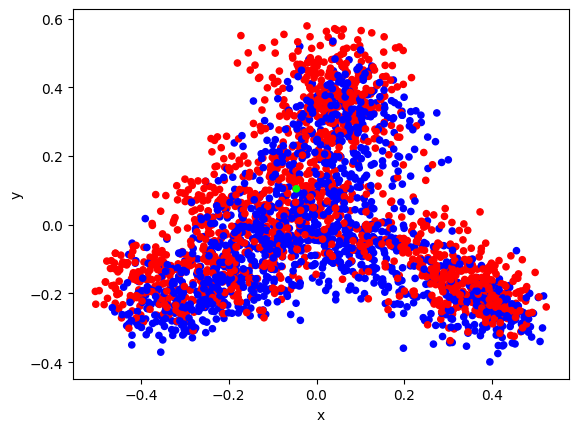

In [15]:
df_3d = pd.concat([
    pd.DataFrame({'x': X_pca[:,0], 'y': X_pca[:,1], 'z': X_pca[:,2],
                  'sentiment': text_df['sentiment'], 
                  'color': [ '#FF0000' if n==1 else '#0000FF' for n in text_df['sentiment']]}),
    df_coef_pca
])

df_3d.plot.scatter(x='x', y='y', c=df_3d['color'].values)

In [16]:
import plotly.express as px
fig = px.scatter_3d(df_3d, x = 'x', y='y', z = 'z', color='color', width=1200, height=1200)
fig.layout.scene.aspectratio = {'x':1, 'y':1, 'z':1}
fig.show()

<Axes: xlabel='num_components'>

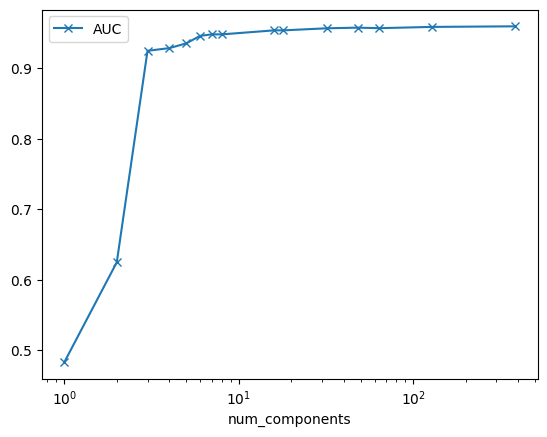

In [17]:
num_components_list = [1,2,3,4,5,6,7,8,16,18,32,48,64,128,384]
pca_models = []
for num_components in num_components_list:
    my_clf = LogisticRegressionCV(cv=5, scoring='roc_auc', n_jobs=-1, max_iter=10000)
    my_clf.fit(X_pca[:,0:num_components], y)
    pca_models.append(my_clf)

pca_performance_df = pd.DataFrame({'num_components': num_components_list, 'AUC': [get_mean_xval_score_for_binary_classifier(clf) for clf in pca_models]})

pca_performance_df.plot(x='num_components', y='AUC', logx=True, marker='x')

## To Do: Normalize the 3d vectors (and the coefficient vector) to unit length. Show points on a sphere.

This is mostly for fun, to help visualize what is going on with hyperspheres (?)

In [18]:
unit_vector_list = []
for row in df_3d.to_dict(orient='records'):
    unit_vector = to_unit_vector([row['x'], row['y'], row['z']])
    unit_vector_list.append({'x_unit': unit_vector[0], 'y_unit': unit_vector[1], 'z_unit': unit_vector[2]})

unit_vector_df = pd.DataFrame(unit_vector_list)

df_3d_unit = pd.concat([df_3d.reset_index(drop=True), unit_vector_df], axis=1)
df_3d_unit

x         y         z sentiment    color    x_unit    y_unit  \
0    -0.193805 -0.132629  0.109469         0  #0000FF -0.747984 -0.511879   
1    -0.158579 -0.020862 -0.119280         1  #FF0000 -0.794784 -0.104561   
2    -0.131406 -0.021342 -0.133600         1  #FF0000 -0.696724 -0.113159   
3    -0.389379 -0.274278  0.045716         0  #0000FF -0.813799 -0.573238   
4    -0.297461 -0.121682 -0.269128         1  #FF0000 -0.709610 -0.290280   
...        ...       ...       ...       ...      ...       ...       ...   
2744  0.415554 -0.258542  0.152345         0  #0000FF  0.810711 -0.504394   
2745  0.073379 -0.113363  0.236107         0  #0000FF  0.269778 -0.416780   
2746  0.039865  0.098133  0.029160         0  #0000FF  0.362864  0.893241   
2747 -0.010065 -0.119390  0.084836         0  #0000FF -0.068556 -0.813243   
2748 -0.045942  0.104422 -0.777621      None  #00FF00 -0.058454  0.132862   

        z_unit  
0     0.422492  
1    -0.597818  
2    -0.708358  
3     0.095547  
4    -0.642021  
...        ...  
2744  0.297212  
2745  0.868052  
2746  0.265425  
2747  0.577872  
2748 -0.989409  

[2749 rows x 8 columns]

In [19]:

fig = px.scatter_3d(df_3d_unit, x = 'x_unit', y='y_unit', z = 'z_unit', color='color', width=1200, height=1200)
fig.layout.scene.aspectratio = {'x':1, 'y':1, 'z':1}
fig.show()

In [21]:
# text_df2 = tg_utils.add_cluster_cols(text_df, embedding_col='weighted', prefix='w', letters='ABC', max_threshold=4)

# What if we pretend this is a regression problem?

Here we try to predict the ones and zeroes as though they are actually ones and zeroes, instead of categories.

In [29]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(text_df, test_size=0.2)

In [47]:
logreg_clf = LogisticRegressionCV(cv=5, scoring='roc_auc', n_jobs=-1, max_iter=10000)
X_train = [v for v in train_df['vector']]
y_train = train_df['sentiment']
X_test = [v for v in test_df['vector']]
y_test = test_df['sentiment']
logreg_clf.fit(X_train, y_train)
clf_score = logreg_clf.predict_proba(X_test)[:,1].tolist()

In [69]:
from sklearn.linear_model import ElasticNetCV

l1_ratios = [.001, .1, .5, .7, .9, .95, .99, 1]
regr = ElasticNetCV(cv=5, l1_ratio=l1_ratios, random_state=0, n_jobs=-1)

regr.fit(X_train, y_train)
regr_score = regr.predict(X_test)

Text(0.5, 0.35, 'AUC from classifier scores: 0.957')

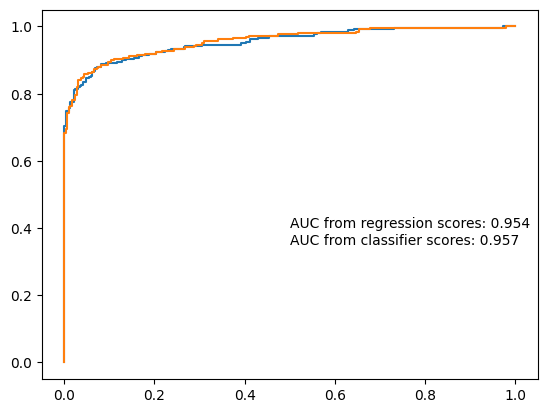

In [70]:
import matplotlib.pyplot as plt
from sklearn import metrics

regr_fpr, regr_tpr, thresholds = metrics.roc_curve(y_test, regr_score)
regr_auc = metrics.auc(regr_fpr, regr_tpr)

clf_fpr, clf_tpr, thresholds = metrics.roc_curve(y_test, clf_score)
clf_auc = metrics.auc(clf_fpr, clf_tpr)


plt.plot(regr_fpr, regr_tpr)
plt.text(0.5, 0.4,  f"AUC from regression scores: {regr_auc:0.3f}")

plt.plot(clf_fpr, clf_tpr)
plt.text(0.5, 0.35, f"AUC from classifier scores: {clf_auc:0.3f}")


<Axes: xlabel='logreg_coef', ylabel='elasticnet_coef'>

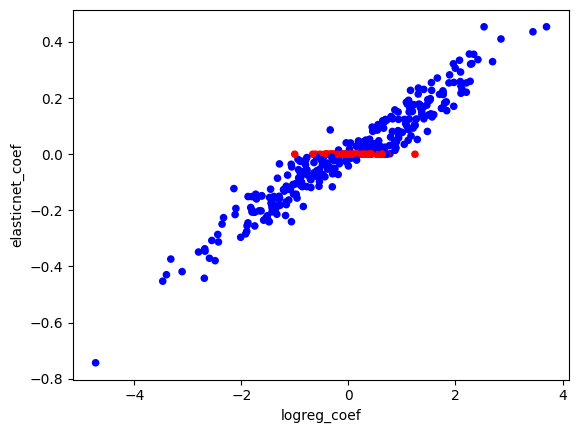

In [71]:
coef_df = pd.DataFrame({
    'logreg_coef':logreg_clf.coef_[0], 
    'elasticnet_coef': regr.coef_, 
    'color': ['red' if coef==0 else 'blue' for coef in regr.coef_]
})

coef_df.plot.scatter(x='logreg_coef', y='elasticnet_coef', c='color')

# plt.scatter(logreg_clf.coef_[0], regr.coef_)


# Discussion

Vector similarity searching is very flexible. Here we show that we can use a vector of coefficients from a logistic regression model as a query vector. To appreciate the power of this approach, try to imagine how you would come up with a semantic vector that would cover most of the positive movie reviews in this dataset!

Accelerated vector searching algorithms should work for this type of query just as well as they work for other vector queries. Stay tuned for our demonstration of using this approach to search a big vector database in (more or less) constant time.

# To Do
* ? normalize the coefficient vector to unit length before weighting with it (or would that not make a difference?)